<a href="https://colab.research.google.com/github/tech09876/pytorch_covid19_x-ray_detection/blob/main/covid19_detection_in_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np  # Numarical Operation
import matplotlib.pyplot as plt    # visualisation

import torch 
import torch.nn as nn # Neural Network
import torchvision
from torch.utils.data import random_split # Split Data
from torch.utils.data import DataLoader
import torchvision.transforms as transform # Data Transform

from tqdm import tqdm
import torch.optim as optim # Optimizer
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid   

In [2]:
data_path_train = "/content/drive/MyDrive/Data/train"

data_path_test = "/content/drive/MyDrive/Data/test"

In [3]:
from torchvision.transforms import transforms
img_size = 227

data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.475], std=[0.229, 0.224, 0.225])
])

In [4]:
train_data = ImageFolder(root= data_path_train, transform= data_transform)
test_data = ImageFolder(root= data_path_test, transform= data_transform)

In [5]:
len(train_data), len(test_data)

(5144, 1288)

In [6]:
train_data.class_to_idx

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [7]:
val_data, test_data = random_split(test_data, [1200, 88])

In [8]:
len(val_data), len(test_data)

(1200, 88)

In [9]:
train_loader = DataLoader(train_data, batch_size= 70, shuffle=True)
val_loader = DataLoader(val_data, batch_size=70, shuffle=True)

In [10]:
for img, labels in train_loader:
  print(img.shape)
  break

torch.Size([70, 3, 227, 227])


In [11]:
def img_show(data):       # visualisation of Image
  for img, labels in(data):
    plt.figure(figsize=(12,6))
    plt.imshow(make_grid(img, n_rows=5).permute(1,2,0))
    plt.show()
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


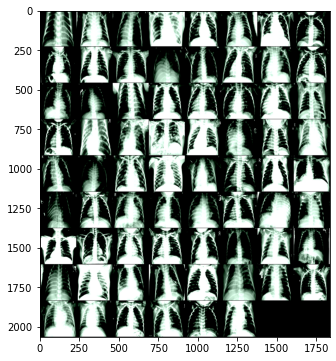

In [12]:
img_show(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


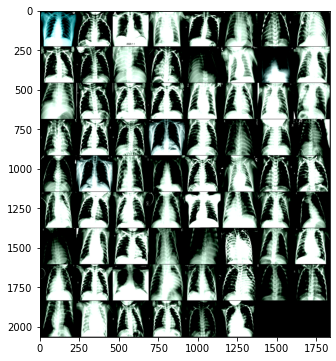

In [13]:
img_show(val_loader)

In [14]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(DEVICE)

cuda:0


In [15]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),   # creating CNN Arctitecture (AlexNet)|Equation : n-f+2p/s+1
            nn.BatchNorm2d(96),  # (227-11)/4+1 = 55
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # (55-3)/2+1 = 27
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # (27+2*2-5)/1+1 = 27
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # (27-3)/2+1 = 13
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), # (13+2*1-3)/1+1 =13
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1), # (13+2*1-3)/1+1 = 13
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), # (13+2*1-3)/1+1 = 13
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # (13-13)/2+6 = 6
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096), # Input = (256*6*6) = 9216 Neurons
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), # Hiddin Layer = 4096 Neurons
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes)) # Output = 3 Neurons
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [16]:
model = AlexNet().to(DEVICE)
print(model)

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.005)

In [18]:
train_accu = [ ]
train_losses = [ ]

def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0
 
  for data in tqdm(train_loader):
     
    inputs,labels=data[0].to(DEVICE),data[1].to(DEVICE)
     
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
 
    running_loss += loss.item()
     
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
       
  train_loss=running_loss/len(train_loader)
  accu=100.*correct/total
   
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [19]:
eval_losses=[]
eval_accu=[]
 
def test(epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for data in tqdm(val_loader):
      images,labels=data[0].to(DEVICE),data[1].to(DEVICE)
       
      outputs=model(images)
 
      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
   
  test_loss=running_loss/len(val_loader)
  accu=100.*correct/total
 
  eval_losses.append(test_loss)
  eval_accu.append(accu)
 
  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))

In [20]:
epochs=12
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 74/74 [59:58<00:00, 48.64s/it]


Train Loss: 0.563 | Accuracy: 75.894


100%|██████████| 18/18 [15:06<00:00, 50.36s/it]


Test Loss: 0.450 | Accuracy: 79.917

Epoch : 2


100%|██████████| 74/74 [02:48<00:00,  2.28s/it]


Train Loss: 0.312 | Accuracy: 88.375


100%|██████████| 18/18 [00:36<00:00,  2.01s/it]


Test Loss: 0.213 | Accuracy: 94.417

Epoch : 3


100%|██████████| 74/74 [02:47<00:00,  2.26s/it]


Train Loss: 0.235 | Accuracy: 91.369


100%|██████████| 18/18 [00:36<00:00,  2.01s/it]


Test Loss: 0.164 | Accuracy: 94.750

Epoch : 4


100%|██████████| 74/74 [02:48<00:00,  2.28s/it]


Train Loss: 0.195 | Accuracy: 92.691


100%|██████████| 18/18 [00:36<00:00,  2.04s/it]


Test Loss: 0.201 | Accuracy: 93.000

Epoch : 5


100%|██████████| 74/74 [02:48<00:00,  2.28s/it]


Train Loss: 0.188 | Accuracy: 93.274


100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


Test Loss: 0.200 | Accuracy: 92.583

Epoch : 6


100%|██████████| 74/74 [02:50<00:00,  2.30s/it]


Train Loss: 0.159 | Accuracy: 94.868


100%|██████████| 18/18 [00:36<00:00,  2.04s/it]


Test Loss: 0.166 | Accuracy: 95.667

Epoch : 7


100%|██████████| 74/74 [02:49<00:00,  2.28s/it]


Train Loss: 0.152 | Accuracy: 94.498


100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


Test Loss: 0.160 | Accuracy: 95.000

Epoch : 8


100%|██████████| 74/74 [02:48<00:00,  2.27s/it]


Train Loss: 0.133 | Accuracy: 95.684


100%|██████████| 18/18 [00:36<00:00,  2.02s/it]


Test Loss: 0.143 | Accuracy: 95.417

Epoch : 9


100%|██████████| 74/74 [02:48<00:00,  2.27s/it]


Train Loss: 0.121 | Accuracy: 95.626


100%|██████████| 18/18 [00:36<00:00,  2.03s/it]


Test Loss: 0.125 | Accuracy: 95.333

Epoch : 10


100%|██████████| 74/74 [02:49<00:00,  2.30s/it]


Train Loss: 0.128 | Accuracy: 95.490


100%|██████████| 18/18 [00:36<00:00,  2.03s/it]


Test Loss: 0.194 | Accuracy: 93.083

Epoch : 11


100%|██████████| 74/74 [02:47<00:00,  2.27s/it]


Train Loss: 0.107 | Accuracy: 96.365


100%|██████████| 18/18 [00:36<00:00,  2.03s/it]


Test Loss: 0.416 | Accuracy: 87.167

Epoch : 12


100%|██████████| 74/74 [02:47<00:00,  2.27s/it]


Train Loss: 0.113 | Accuracy: 96.404


100%|██████████| 18/18 [00:36<00:00,  2.02s/it]

Test Loss: 0.347 | Accuracy: 90.083


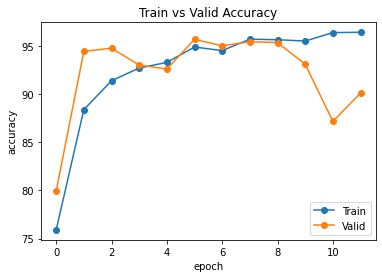

In [21]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

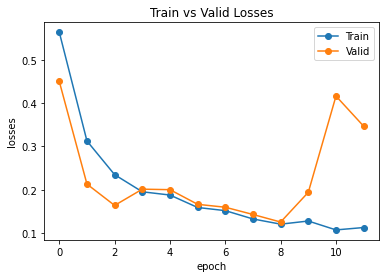

In [22]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [23]:
def predict_img(img, model):
  x = img.unsqueeze(0)
  y = model(x.to(DEVICE))

  Pred = torch.argmax(y, dim=1)

  return train_data.classes[Pred]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label :  PNEUMONIA | prediction label:  PNEUMONIA


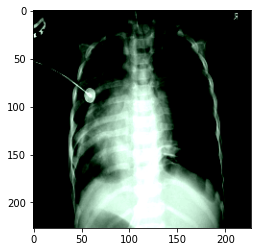

In [36]:
img, label = test_data[71]    # Detecting Images "COVID, NORMAL or VIRAL PNEUMONIA"
plt.imshow(img.permute(1,2,0))
print("Actual Label : ", train_data.classes[label],'|', "prediction label: ",predict_img(img, model) )